# Programming Custom Transformers, Pipelines, and Ensemble Models to Predict Venue Ratings from the Yelp Academic Dataset

<span id='back-up'>The Yelp academic dataset </span> (included in this repository) consists of about 38,000 business listings and their relevant information. Each listing includes 15 properties, e.g. `business_id`, `full_address`, `hours`, `categories`, etc ([Click here to see all of a listing's properties (anchors don't work in Github)](#listing)).

The **goal of this project** is to demonstrate the use of custom transformer classes, chaining custom tranformers/estimators into pipelines for composite estimators, and using feature unions to develop an ensemble model for venues' ratings prediction.

Although I will optimize my models using cross-validation, the goal of the project is *not to develop the best* model to predict star ratings based on the features in the dataset. This dataset doesn't include actual user reviews. A much more accurate predictive model would likely require natural language processing (NLP) of the costumer review data. With that caveat, let's dive into the data.

-------------

### Libraries Used

I will be using the most common python libaries for machine learning and data analysis, namely the numpy, pandas and scikit-learn libraries. I'll be using sci-kit learn's linear and non-linear regressors for modeling the data. As most of the data is not in the correct format (sci-kit learn requires numpy arrays or pandas dataframes as inputs) I'll write custom transformers to modify the original data structure for it.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import dill
import pandas as pd
import numpy as np
import random as rd
from sklearn import base
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Importing and Exploring the Data

In [2]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

<span id='listing'> I always find it nice to see how the data is structured. `data` is a a list of businesses (~38,000). I have just printed the first listed buisness to see all of it's associated metadata ([back to the introduction](#back-up)). </span>

In [3]:
for i in data[0]:
    print (i,':', data[0][i])

business_id : vcNAWiLM4dR7D2nwwJ7nCA
full_address : 4840 E Indian School Rd
Ste 101
Phoenix, AZ 85018
hours : {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}
open : True
categories : ['Doctors', 'Health & Medical']
city : Phoenix
review_count : 7
name : Eric Goldberg, MD
neighborhoods : []
longitude : -111.983758
state : AZ
stars : 3.5
latitude : 33.499313
attributes : {'By Appointment Only': True}
type : business


Keeping the labels separate from the features and splitting the dataset into a training and test dataset.

In [4]:
star_ratings = [business['stars'] for business in data]

In [5]:
np.array(star_ratings).mean()

3.6729137013021247

In [6]:
# from sklearn.model_selection
xtrain, xtest, ytrain, ytest = train_test_split(data, star_ratings, 
                                                train_size=0.8, 
                                                random_state=100)


### Building a City-based Predictive Model

This first estimator takes all the cities in the dataset, calculates the average, and then predicts that average for any venue in a city.

As a a model, it is quite crude, but in some cases where customers in some cities may rate higher than other cities, it would make for a baseline predictor, especially when combined with category data.

I added a default rating of 3.67 (dataset mean) if the city doesn't exist in the dataset.

In [7]:
class CityEstimator(base.BaseEstimator, base.RegressorMixin):

    def fit(self, X, y):
        
        # X is input list of rows. y is corresponding star ratings
        city = [business['city'] for business in X]
        
        # using dataframes for grouped means
        city_stars = pd.DataFrame({'city': city,
                                   'star_ratings': y})
        city_avg = city_stars.groupby(['city'], as_index=False).mean()
        
        # going back to the dictionary as easier to add missing data during predict
        agg_city = city_avg['city'].to_list()
        agg_stars = city_avg['star_ratings'].to_list()

        self.city_agg = {i:j for i,j in zip(agg_city, agg_stars)}
   
        return self

    def predict(self, X):
        
        predX = [business['city'] for business in X]
        predY = []
        for i in predX:
            if i in self.city_agg:
                predY.append(self.city_agg[i])
            else:
                predY.append(3.67) # if city is not in dataset, if just guesses 2.5
        return predY


I'll be using the mean squared error and the mean absolute error as my scoring metric. The former is the sum of the squared difference, whereas the latter is the sum of the absolute difference between actual `y` and predicted `y` 

In [8]:
def pred_score(model, xdata, ydata):
    pred = model.predict(xdata)
    score = []
    score.append(mean_squared_error(ydata, pred))
    score.append(mean_absolute_error(ydata,pred))
    return pred, score

In [9]:
# Initializing Model
city_est = CityEstimator()
city_est.fit(xtrain, ytrain)

CityEstimator()

In [10]:
# Testing with original data
city_test_pred, city_score = pred_score(city_est, xtest, ytest)
print(city_score)

[0.808324517360051, 0.7179545880960081]


At first glance the MSE of 0.81 and MAE of 0.72 looks low. But if we plot our data, we'll see that our data is centered at 3.67. a MAE of 0.72 suggests the average prediction could range from 2.95 to  4.39, a fairly bigger when it comes to user ratings.

Let's plot some subset of the data to visualize our predictions.

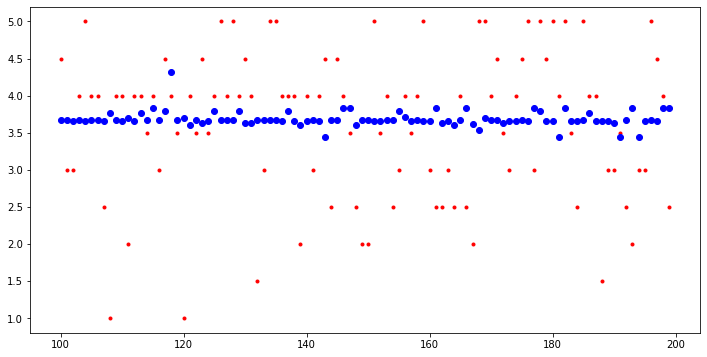

In [11]:
city_venue = list(range(0,len(xtest)))
plt.figure(figsize=(12,6))
w = 100 # shift window to plot
plt.plot(city_venue[w+0:w+100], ytest[w+0:w+100], 'r.' ,label='Actual')
plt.plot(city_venue[w+0:w+100], city_test_pred[w+0:w+100], 'bo' ,label='Pred')

We can see that the model does a really poor job of predicting most venues.

(array([ 102.,  146.,  284.,  620., 1050., 1697., 1667., 2022.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 8 Patch objects>)

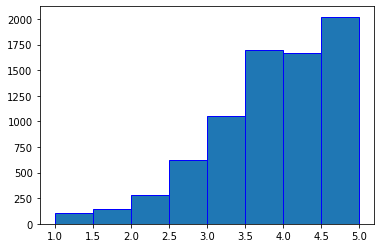

In [12]:
plt.hist(ytest, bins=8, range=(1,5), edgecolor='b')

### Column Select Transformer 

If I want to use particular features as input for a model, I have to make sure it is shaped as a numpy array for sci-kit learn's regressors. The format of a numpy array is `[[$a_{1}$,$b_{1}$], [$a_{2}$,$b_{2}$], ...]

In [13]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, col_names):
        self.col_names = col_names

    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self

    def transform(self, X):
        tx_undata = [] #not formatted so UNformatted DATA
        for i in self.col_names:
            tx_undata.append([row[i] for row in X])

        len_col = len(tx_undata)

        tx_data = []
        for i in tx_undata[0]:
            tx_data.append([i])
        for i in range(1, len(self.col_names)):
            for j in range(len(tx_data)):
                tx_data[j].append(tx_undata[i][j])

        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return tx_data


Testing that our column transformer takes in a list of columns, and then outputs that in a numpy array-like list.

In [14]:
col_in = ['latitude', 'longitude']
cst = ColumnSelectTransformer(col_in)
data_subset = data[0:5]
cst2 = cst.fit_transform(data_subset)
cst3 = [[i['latitude'], i['longitude']] for i in data_subset]
print(cst2)
print(cst2 == cst3)

[[33.499313, -111.983758], [43.238893, -89.335844], [43.252267, -89.353437], [43.251045, -89.374983], [43.2408748, -89.3437217]]
True


I'll use `pipeline` from the sklearn.pipeline library to sequentially apply my column transformer, and then pass that data to a regressor. In this case I will be using a k-nearest neighbors regressor, which averages the value of the k nearest neighbors (Euclidean distance) to predict the value for input (lat, long).

In [15]:
col_in = ['latitude', 'longitude']

pipe = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                 ('knear', KNeighborsRegressor(n_jobs=-1))])


I'm using the exhaustive `GridSearchCV` function from the scikit library to optimize the `n_neighbors` and `weights` of each neighbor in the knn algorithm. Note that to pipe the parameter grid, I have to append the estimator name (that I can name arbitrarily) as `name__`. In this particular case, it is `knear__`. 

In [ ]:
kparams = { 'knear__n_neighbors': [90, 100, 110, 120, 200],
            'knear__weights': ['uniform', 'distance']}

cn = GridSearchCV(pipe, kparams, cv=5, scoring='neg_mean_squared_error')
cn.fit(xtrain, ytrain)

In [ ]:
cn.best_params_

In [16]:
pipe = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                 ('knear', KNeighborsRegressor(n_neighbors=100, n_jobs=-1))])
pipe.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('columntx',
                 ColumnSelectTransformer(col_names=['latitude', 'longitude'])),
                ('knear',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=-1, n_neighbors=100, p=2,
                                     weights='uniform'))],
         verbose=False)

In [17]:
print(pred_score(pipe,xtest, ytest)[1])

[0.7994039536109647, 0.7094517659462309]


The latitude and longitude model barely improves our predictions.

## Category Model

Now I'll build a model based on the `categories` data. The data looks like like the following:

In [18]:
# Examples

print(data[rd.randrange(0,len(data))]['categories'])
print(data[rd.randrange(0,len(data))]['categories'])
print(data[rd.randrange(0,len(data))]['categories'])

['Food', 'Coffee & Tea']
['Local Services', 'Sewing & Alterations', 'Shoe Repair', 'Watch Repair']
['Diners', 'Restaurants']


I'm making a `DictEncoder` function which takes in our category column and reformats it into a format that can be used with the standark sci-kit library. Each category will become a key with a value of 1 for each venue. We'll use the scikit-learn `DictVectorizer` function to convert the categorical input (the general term) into numerical features via *one-hot encoding*, converting each category into a seperate feature (column). If you look at the print statement below, you'll notice the data is represented as a sparse matrix, to save memory (as most features will be zero for most venues).

In [19]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ct_dt = []
        # the extra loop is because this is a list nested in a list nested in a list
        for i in X:
            for j in i:
                ct_dt.append({})
                for k in j:
                    ct_dt[-1][k] = 1

        return ct_dt

In [20]:
col_in = ['categories']
cst = ColumnSelectTransformer(col_in).fit_transform(data_subset)
for i in cst:
    print(i)
print('\n')

cst2 = DictEncoder().fit_transform(cst)
for i in cst2:
    print(i)

cst3 = DictVectorizer().fit_transform(cst2)
for i in cst3:
    print(i)


[['Doctors', 'Health & Medical']]
[['Restaurants']]
[['American (Traditional)', 'Restaurants']]
[['Food', 'Ice Cream & Frozen Yogurt', 'Fast Food', 'Restaurants']]
[['Chinese', 'Restaurants']]


{'Doctors': 1, 'Health & Medical': 1}
{'Restaurants': 1}
{'American (Traditional)': 1, 'Restaurants': 1}
{'Food': 1, 'Ice Cream & Frozen Yogurt': 1, 'Fast Food': 1, 'Restaurants': 1}
{'Chinese': 1, 'Restaurants': 1}
  (0, 2)	1.0
  (0, 5)	1.0
  (0, 7)	1.0
  (0, 0)	1.0
  (0, 7)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 1)	1.0
  (0, 7)	1.0


We make a pipe with all our transformers, and this time I used a linear regressor (probably not the best approach) as an estimator. I used cross-validation to find the optimum alpha (the hyperparmater).

In [ ]:
col_in = ['categories']
pipe2 = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                  ('dict_enc', DictEncoder()),
                  ('dict_vec', DictVectorizer()),
                  ('ridge', Ridge())])

kparams = { 'ridge__alpha': [3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 10.0]}

catn = GridSearchCV(pipe2, kparams, cv=5, scoring='neg_mean_squared_error')
catn.fit(xtrain, ytrain)
catn.best_params_

In [21]:
col_in = ['categories']
pipe2 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictEncoder()),
                  ('dict vector', DictVectorizer()),
                  ('ridge model', Ridge(alpha=7.0))])

pipe2.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('column tx',
                 ColumnSelectTransformer(col_names=['categories'])),
                ('dict fixer', DictEncoder()),
                ('dict vector',
                 DictVectorizer(dtype=<class 'numpy.float64'>, separator='=',
                                sort=True, sparse=True)),
                ('ridge model',
                 Ridge(alpha=7.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [22]:
print(pred_score(pipe2, xtest, ytest)[1])

[0.6695331404441529, 0.6356787689205778]


The category model seems to improve our prediction by about ~17% over our previous models.

## Attribute Model

Similar to the category model above, I'll use the attributes of each venue to generate my prediction. The custom transformer `DictAttEncoder` is converting the original input into a dictionary that can be used by `DictVectorizer` to feed into our scikit-learn estimator. In this case, I used a random forest model. Once again, I used cross validation to optimize the hyperparamters for my model.


In [23]:
class DictAttEncoder(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #self.at_lt = X   # attribute list
        at_dt = []  # attribute flat dictionary
        for i in X:
            for j in i:
                at_dt.append({})
                for k, l in j.items():
                    if not type(l) is dict:
                        if l == False:
                            at_dt[-1][k] = 0
                        elif l == True:
                            at_dt[-1][k] = 1
                        else:
                            at_dt[-1]['{}_{}'.format(k, l)] = 1
                    if type(l) is dict:
                        for m, n in l.items():
                            if n == False:
                                at_dt[-1]['{}_{}'.format(k, m)] = 0
                            elif n == True:
                                at_dt[-1]['{}_{}'.format(k, m)] = 1

        return at_dt

In [24]:
col_in = ['attributes']
cst = ColumnSelectTransformer(col_in).fit_transform(data_subset)
for i in cst:
    print(i)
print('\n')

cst2 = DictAttEncoder().fit_transform(cst)
for i in cst2:
    print(i)


[{'By Appointment Only': True}]
[{'Take-out': True, 'Good For': {'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'breakfast': False, 'brunch': False}, 'Caters': False, 'Noise Level': 'average', 'Takes Reservations': False, 'Delivery': False, 'Ambience': {'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}, 'Parking': {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}, 'Has TV': True, 'Outdoor Seating': False, 'Attire': 'casual', 'Alcohol': 'none', 'Waiter Service': True, 'Accepts Credit Cards': True, 'Good for Kids': True, 'Good For Groups': True, 'Price Range': 1}]
[{'Take-out': True, 'Good For': {'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'breakfast': False, 'brunch': True}, 'Caters': False, 'Noise Level': 'quiet', 'Takes Reservations': False, 'Delivery': False, 'Parking': {'garage': False, 'stre

In [ ]:
col_in = ['attributes']
pipe3 = Pipeline([('columntx', ColumnSelectTransformer(col_in)),
                  ('dict_fix', DictAttEncoder()),
                  ('dict_vec', DictVectorizer()),
                 ('forest', RandomForestRegressor(n_jobs=-1))])

kparams = { 'forest__n_estimators': [200, 300, 400],
            'forest__max_depth': [10, 25, 40],
            'forest__min_samples_split': [2, 10, 25, 50]}

fn = GridSearchCV(pipe3, kparams, cv=5, scoring='neg_mean_squared_error')
fn.fit(xtrain, ytrain)
fn.best_params_



In [25]:
col_in = ['attributes']
pipe3 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictAttEncoder()),
                  ('dict vector', DictVectorizer()),
                 ('forest model', RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50))])

pipe3.fit(xtrain, ytrain)

print(pred_score(pipe3, xtest, ytest)[1])

[0.7349957500528327, 0.673658764501434]


## Residual Estimator

A single regressor doesn't really do a good job here. Here I took the residual of my first estimator, and then estimated that again. Typically a linear model is used to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit. However, in this case, the non-linear model worked better in both cases.

In [26]:
class DataAndResidualRegressor(base.BaseEstimator, base.TransformerMixin):

    def fit(self, X, y):
        self.data = X
        self.y_act = y

        self.data_model1 = RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50)
        #self.data_model2 = Ridge(alpha=3.0)
        self.data_model2 = RandomForestRegressor(n_jobs=-1, max_depth=40,
                                                        n_estimators=300,
                                                        min_samples_split=50)

        self.data_model1.fit(self.data, self.y_act)
        self.y_est = self.data_model1.predict(self.data)
        self.y_res = self.y_act - self.y_est

        self.data_model2.fit(self.data, self.y_res)

        return self

    def predict(self, X):
        y_predict = self.data_model1.predict(X) + self.data_model2.predict(X)

        return y_predict


In [27]:
col_in = ['attributes']
pipe4 = Pipeline([('column tx', ColumnSelectTransformer(col_in)),
                  ('dict fixer', DictAttEncoder()),
                  ('dict vector', DictVectorizer()),
                  ('data res model', DataAndResidualRegressor())])

pipe4.fit(xtrain, ytrain)
print(pred_score(pipe4, xtest, ytest)[1])

[0.7353600445263452, 0.6732220126103124]


## Custom Estimator Transformer

So far I have only built a model based on individual features.  Now I'll build an ensemble regressor that averages together the estimates of the four previous regressors.

Unfortunately, a pipeline can only container one estimator (at most). So we'll take our old models, fit our data, and then use that output as features for our ensemble estimator. In order to do this, we'll transform our models into tranformers (again by making a custom class).

`EstimatorTransformer` will take an estimator as an argument.  When `fit()` is called, the estimator will be fit.  When `transform()` is called, the estimator's `predict()` method will be called, and its results returned. The output of the `transform()` will be our predicted values from each model, so it will be a single column.

In [28]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, estimator):
        self.estimator = estimator
        #return self

    def fit(self, X, y):
        self.estimator.fit(X,y)
        return self

    def transform(self, X):
        self.y_est = self.estimator.predict(X)
        self.y_out = [[i] for i in self.y_est]

        return self.y_out

Just testing my estimator transformer on one of the models:

In [29]:

city_est = CityEstimator()
city_trans = EstimatorTransformer(city_est)

city_trans.fit(data, star_ratings)

assert ([r[0] for r in city_trans.transform(data[:5])]
        == city_est.predict(data[:5]))


Putting all the models together and making a union of the features (using the `FeatureUnion` function from scikit-learn library)

In [32]:

city_trans = EstimatorTransformer(city_est)
latlong_trans = EstimatorTransformer(pipe)
cat_trans = EstimatorTransformer(pipe2)
att_trans = EstimatorTransformer(pipe4)


union = FeatureUnion([('city est', city_trans),
                      ('lat long', latlong_trans),
                      ('cat mod', cat_trans),
                      ('att mod', att_trans)])

In [33]:
lr_model = LinearRegression()
#lr_model = RandomForestRegressor(n_estimators=20)

pipe5 = Pipeline([('columns all', union),
                 ('lin model', lr_model)])

pipe5.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('columns all',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('city est',
                                                 EstimatorTransformer(estimator=CityEstimator())),
                                                ('lat long',
                                                 EstimatorTransformer(estimator=Pipeline(memory=None,
                                                                                         steps=[('columntx',
                                                                                                 ColumnSelectTransformer(col_names=['latitude',
                                                                                                                                    'longitude'])),
                                                                                                ('knear',
                                                                         

In [34]:
pipe5_y, p5_score = pred_score(pipe5, xtest, ytest)
print(p5_score)

[0.6564442744819269, 0.6271389077898223]


In summary, I built individual predictive models, based on the different metadata of each venue in our dataset. This required some custom transformers and estimators as needed. Eventually, I combined the separate models into one ensemble model, which was fit using a Linear Regressor.

The fit is probably not as good as it can get, but that was expected based on the lack of user data. That being said, if we look at our original city based model, and compare it ot our ensemble model, we do see an improvement in our predictions.

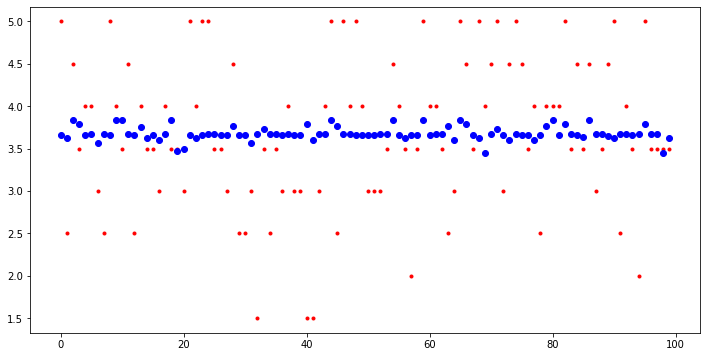

In [36]:
city_venue = list(range(0,len(xtest)))
plt.figure(figsize=(12,6))
plt.plot(city_venue[0:100], ytest[0:100], 'r.' ,label='Actual')
plt.plot(city_venue[0:100], city_test_pred[0:100], 'bo' ,label='Pred')

The above plot is from the city model, whereas the one below is from our ensemble model. Although not great (especially for outliers), it's much improved over the original model.

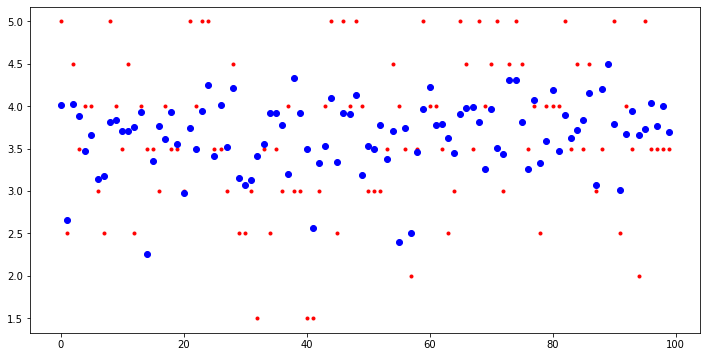

In [35]:
city_venue = list(range(0,len(xtest)))
plt.figure(figsize=(12,6))
plt.plot(city_venue[0:100], ytest[0:100], 'r.' ,label='Actual')
plt.plot(city_venue[0:100], pipe5_y[0:100], 'bo' ,label='Pred')